In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
import sys

import scipy
from scipy import io

import torch
import torch.nn as nn
import torch.optim as optim

cmap = plt.get_cmap('inferno')
cmap2 = plt.get_cmap('seismic')

import seaborn as sns

# Define a discrete color palette with a specified number of colors
#sns.set_palette(sns.color_palette("muted", n_colors=10))  # or use another color map and adjust `n_colors`
custom_palette = ["#FFB347", "#779ECB", "#77DD77", "#FF6961", "royalblue", "#CB99C9", "#FDFD96", "#AEC6CF"]
costum_palette_pairs = ['#ffb347', '#ffcc84', '#ffe6c2', 
                        '#779ecb', '#a4bedc', '#d2dfee', 
                        '#77dd77', '#a4e8a4', '#d2f4d2', 
                        '#ff6961', '#ff9b96', '#ffcdca', 
                        '#cb99c9', '#dcbbdb', '#eedded', 
                        '#fdfd96', '#fefeb9', '#fefedc',
                        '#aec6cf', '#c9d9df', '#e4ecef']

sns.set_palette(custom_palette)
colors = sns.color_palette()
colors_pairs = sns.color_palette(costum_palette_pairs) #("tab20c")

cmap = plt.get_cmap('inferno')
cmap2 = plt.get_cmap('seismic')

# set title font size
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [61]:
X_star = np.load('./Cylinder2D_small_X_star.npy')
sol_star = np.load('./Cylinder2D_small_sol_star.npy')
sol_star = sol_star[:, 0:3] # Remove fourth column in solution since this is the concentration

In [62]:
X_star.shape

(832167, 3)

In [106]:
# Training data points
N_data = 10000
idx_data = np.random.choice(X_star.shape[0], N_data, replace=False)
X_data = X_star[idx_data]
sol_data = sol_star[idx_data]

# Training points for the velocity at the inlet
idx_inlet = np.where(X_star[:, 0]==-1.0)[0]
X_inlet = X_star[idx_inlet]
sol_inlet = sol_star[idx_inlet]

# Training collocation points
N_colloc = 10000
idx_colloc = np.random.choice(X_star.shape[0], N_colloc, replace=False)
X_colloc = X_star[idx_colloc]
X_colloc_train = np.concatenate((X_colloc, X_data, X_inlet), axis=0)

# Define the PDE parameters
Pe = 100
Re = 100

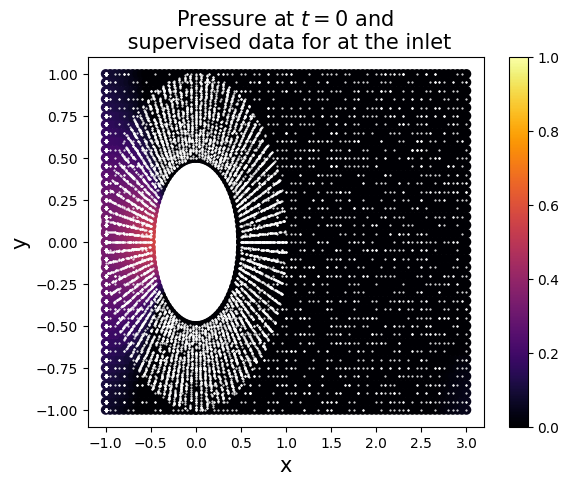

In [107]:
index_t = np.where(X_star[:, -1]==0)
plt.scatter(X_star[index_t, 0], X_star[index_t, 1], c=sol_star[index_t, -1], cmap=cmap, vmax=1, vmin=0)
plt.plot(X_inlet[:, 0], X_inlet[:, 1], "*", markersize=2, color='white')
plt.plot(X_data[:, 0], X_data[:, 1], "o", markersize=0.5, color='white', label='Training data')
plt.colorbar()
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Pressure at $t=0$ and \n supervised data for at the inlet', fontsize=15)
plt.show()

In [115]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)

import torch

def f_user(X_f, model_nn, Re=100):
    # Extract x, y, t from the input tensor
    x_temp = X_f[:, 0:1]
    y_temp = X_f[:, 1:2]
    t_temp = X_f[:, 2:3]

    x_temp.requires_grad = True
    y_temp.requires_grad = True
    t_temp.requires_grad = True


    # Model predictions
    X_temp = torch.cat([x_temp, y_temp, t_temp], dim=1)
    pred = model_nn(X_temp)
    
    # Outputs: momentum components (w_x, w_y) and pressure (p)
    w_x = pred[:, 0:1]
    w_y = pred[:, 1:2]
    p = pred[:, 2:3]

    # First-order derivatives
    w_x_t = torch.autograd.grad(w_x, t_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_t = torch.autograd.grad(w_y, t_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]

    w_x_x = torch.autograd.grad(w_x, x_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_x = torch.autograd.grad(w_y, x_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    p_x = torch.autograd.grad(p, x_temp, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    w_x_y = torch.autograd.grad(w_x, y_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_y = torch.autograd.grad(w_y, y_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y_temp, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # Second-order derivatives
    w_x_xx = torch.autograd.grad(w_x_x, x_temp, grad_outputs=torch.ones_like(w_x_x), create_graph=True)[0]
    w_y_xx = torch.autograd.grad(w_y_x, x_temp, grad_outputs=torch.ones_like(w_y_x), create_graph=True)[0]

    w_x_yy = torch.autograd.grad(w_x_y, y_temp, grad_outputs=torch.ones_like(w_x_y), create_graph=True)[0]
    w_y_yy = torch.autograd.grad(w_y_y, y_temp, grad_outputs=torch.ones_like(w_y_y), create_graph=True)[0]

    # Navier-Stokes momentum equations
    f_1 = w_x_t + (w_x * w_x_x + w_y * w_x_y) - (1.0 / Re) * (w_x_xx + w_x_yy) + p_x
    f_2 = w_y_t + (w_x * w_y_x + w_y * w_y_y) - (1.0 / Re) * (w_y_xx + w_y_yy) + p_y

    # Continuity equation (incompressibility constraint)
    f_3 = w_x_x + w_y_y

    return f_1, f_2, f_3

def loss_f(f):
    return torch.mean(f[0]**2) + torch.mean(f[1]**2) + torch.mean(f[2]**2)

In [116]:
# Depth and width of the neural networks
layers = [3] + [64]*4 + [3]

# Learning rate for Adam optimizer
lr = 0.001

In [117]:
import sys
sys.path.append('../')  # Ensure the module path is accessible

# Reload the updated module
import importlib
import pinns  # Import the module
importlib.reload(pinns)

# Import the updated PINNs class
from pinns import PINNs

In [118]:
sol_data

array([[ 0.14653385, -0.19139283, -0.32393012],
       [ 0.07504429,  0.01447915, -0.42382854],
       [-0.02052316, -0.1890212 , -0.30675049],
       ...,
       [ 1.09006231, -0.39661842, -0.41960811],
       [ 0.27170528,  0.15604439, -0.42677773],
       [-0.13962742,  0.04420905, -0.25097238]])

In [119]:
# Convert data to PyTorch tensors
X_data_tensor = torch.tensor(X_data, dtype=torch.float64)
sol_data_tensor = torch.tensor(sol_data, dtype=torch.float64)
X_inlet_tensor = torch.tensor(X_inlet, dtype=torch.float64)
sol_inlet_tensor = torch.tensor(sol_inlet, dtype=torch.float64)


In [120]:
model_pinn = PINNs(X_colloc_train, 
             net_transform, 
             f_user, 
             loss_f,
             layers, 
             lr,
             type_problem='forward',
             X_data=X_data_tensor, 
             u_data=sol_data_tensor, 
             X_other=X_inlet_tensor, 
             u_other=sol_inlet_tensor)

model_pinn.net_u = model_pinn.net_u.double()
model_pinn.train(max_epochs_adam=5000, max_epochs_lbfgs=1000, print_per_epochs=10)

No data on the boundary
No data at the initial instant
No data for testing
Loss at epoch 0 (Adam): 0.8516167179286434
Loss at epoch 10 (Adam): 0.4552244361818158
Loss at epoch 20 (Adam): 0.4068068080491163
Loss at epoch 30 (Adam): 0.3834884628865877
Loss at epoch 40 (Adam): 0.36876718396164543
Loss at epoch 50 (Adam): 0.3547872256120365
Loss at epoch 60 (Adam): 0.3373976990295763
Loss at epoch 70 (Adam): 0.31178381452544907
Loss at epoch 80 (Adam): 0.2792039996210397
Loss at epoch 90 (Adam): 0.2519447898878701
Loss at epoch 100 (Adam): 0.23629382387050446
Loss at epoch 110 (Adam): 0.2207468102017688
Loss at epoch 120 (Adam): 0.21369894897911712
Loss at epoch 130 (Adam): 0.19946144946368374
Loss at epoch 140 (Adam): 0.18791359500241894
Loss at epoch 150 (Adam): 0.17845022680905062
Loss at epoch 160 (Adam): 0.16984039115297925
Loss at epoch 170 (Adam): 0.16180766915324687
Loss at epoch 180 (Adam): 0.15456040984423414
Loss at epoch 190 (Adam): 0.14773823574953343
Loss at epoch 200 (Adam):

In [123]:
# make xstar tensor
X_star_tensor = torch.tensor(X_star, dtype=torch.float64)

with torch.no_grad():  # Disable gradient computation for inference
    pred = model_pinn.net_u(X_star_tensor).detach().numpy()



In [127]:
# plot the reference, the prediction and the error

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

inlet = np.where(X_star[:, 0]==-1.0)[0]


Error in callback <function _draw_all_if_interactive at 0x11d3bdfc0> (for post_execute):


KeyboardInterrupt: 

: 

: 